### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('age_gender.csv')

In [3]:
df.shape

(23705, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


### Data Preprocessing

In [5]:
df.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

**We see that there are no null values in the dataset**

In [6]:
df.nunique()

age            104
ethnicity        5
gender           2
img_name     23479
pixels       23315
dtype: int64

**We can drop the image name and ethnicity as we are concerned with only the age and gender**

In [7]:
df.drop(['img_name','ethnicity'],axis=1,inplace=True)

In [8]:
df['gender'].value_counts()

gender
0    12391
1    11314
Name: count, dtype: int64

In [9]:
df['age'].nunique()

104

**We now need to identify the pixel values given in the dataset and the image height and width**

In [10]:
no_of_pixels = len(df['pixels'][0].split(' '))
height = width = int(np.sqrt(no_of_pixels))

In [11]:
print("Number of pixels:",no_of_pixels)
print("Image height:",height)
print("Image width:",width)

Number of pixels: 2304
Image height: 48
Image width: 48


In [12]:
def pixel_reshape(x):
    x = np.array(x.split(' '),dtype=np.float32)
    x = x.reshape(48,48)
    return x

In [13]:
df['pixels'] = df['pixels'].map(pixel_reshape)

**Let us view some images from the dataset with their corresponding age and gender**

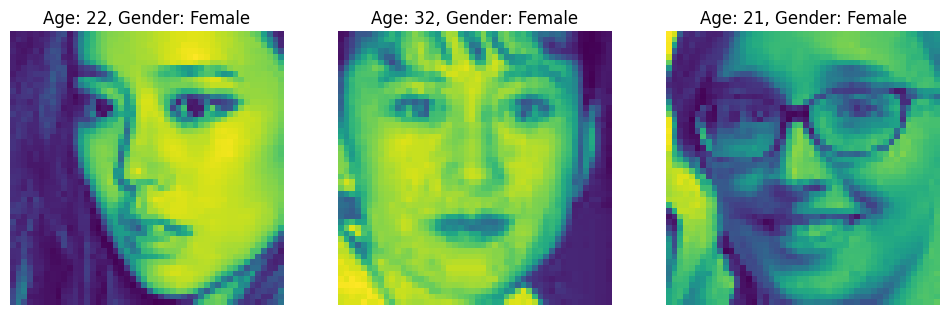

In [14]:
fig, axes = plt.subplots(1,3,figsize=(12,5))
for i in range(3):
    img = np.random.choice(len(df))
    age = df['age'][img]
    gender = df['gender'][img]
    gender_dict = {0: 'Male', 1: 'Female'}  
    axes[i].set_title("Age: {}, Gender: {}".format(age,gender_dict[gender]))
    axes[i].imshow(df['pixels'][img])
    axes[i].axis("off")

### Train Test Split

In [15]:
X = np.array(df['pixels'].to_list())
y = df.drop('pixels',axis=1)

In [16]:
X.shape[0]

23705

In [17]:
X_reshaped = X.reshape(X.shape[0],height,width,1)
X_reshaped = X_reshaped/255.0

input_shape = (height,width,1)
epochs=15
batch_size=64

In [18]:
y_age = y['age'].values

**Let's first build the neural network model for age prediction**

### Age model building

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped,y_age,test_size=0.25,random_state=42)

In [20]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.4))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

In [21]:
age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [22]:
age_model.compile(optimizer='adam',
                  loss='mse')

In [23]:
callbacks =  [EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1)]

In [24]:
history = age_model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/15


2023-10-30 13:34:15.870297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


278/278 [==============================] - 16s 17ms/step - loss: 288.4726 - val_loss: 867.6606 - lr: 0.0010
Epoch 2/15
278/278 [==============================] - 4s 14ms/step - loss: 154.5377 - val_loss: 867.4327 - lr: 0.0010
Epoch 3/15
278/278 [==============================] - 4s 14ms/step - loss: 136.3515 - val_loss: 211.8661 - lr: 0.0010
Epoch 4/15
278/278 [==============================] - 4s 14ms/step - loss: 125.6556 - val_loss: 215.5735 - lr: 0.0010
Epoch 5/15
277/278 [============================>.] - ETA: 0s - loss: 116.0264
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
278/278 [==============================] - 4s 13ms/step - loss: 116.0833 - val_loss: 401.3714 - lr: 0.0010
Epoch 6/15
278/278 [==============================] - 4s 14ms/step - loss: 100.3029 - val_loss: 83.8091 - lr: 1.0000e-04
Epoch 7/15
278/278 [==============================] - 4s 14ms/step - loss: 97.8396 - val_loss: 105.1688 - lr: 1.0000e-04
Epoch 8/15
276/278 [=============

In [26]:
y_pred = age_model.predict(X_test)

186/186 [==============================] - 1s 3ms/step


In [27]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score,confusion_matrix, classification_report
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))
print("Mean Squared Error: {}".format(np.sqrt(mean_squared_error(y_test,y_pred))))
print("R2 score: {}".format(r2_score(y_test,y_pred)))

MAE: 6.347747947808882
Mean Squared Error: 8.895412493046848
R2 score: 0.7979797945775797


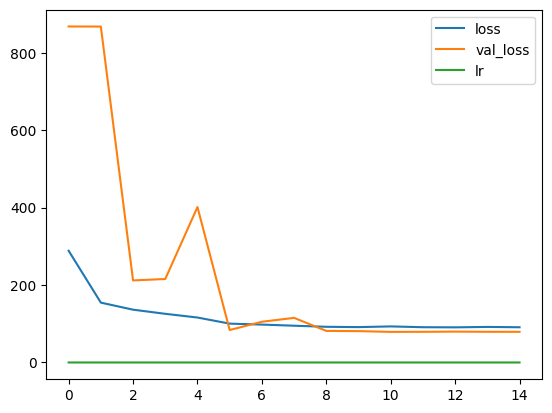

In [28]:
pd.DataFrame(history.history).plot();

### Gender model building

In [29]:
y = df['gender'].values
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [30]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.3))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid'))

In [31]:
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 23, 23, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                      

In [32]:
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [33]:
history = gender_model.fit(X_train, y_train, 
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/15


2023-10-30 13:37:56.379277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


297/297 [==============================] - 7s 12ms/step - loss: 0.5236 - accuracy: 0.7504 - val_loss: 1.5253 - val_accuracy: 0.5206 - lr: 0.0010
Epoch 2/15
297/297 [==============================] - 3s 11ms/step - loss: 0.3841 - accuracy: 0.8278 - val_loss: 0.3407 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 3/15
297/297 [==============================] - 3s 11ms/step - loss: 0.3405 - accuracy: 0.8448 - val_loss: 0.3437 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 4/15
297/297 [==============================] - 3s 11ms/step - loss: 0.3143 - accuracy: 0.8613 - val_loss: 0.3350 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 5/15
297/297 [==============================] - 3s 11ms/step - loss: 0.2946 - accuracy: 0.8700 - val_loss: 0.2792 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 6/15
297/297 [==============================] - 3s 11ms/step - loss: 0.2829 - accuracy: 0.8747 - val_loss: 0.2773 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 7/15
297/297 [==============================] - 3s 11ms/step - loss: 

## Evaluating the model

In [34]:
acc = gender_model.evaluate(X_test, y_test)

149/149 [==============================] - 0s 3ms/step - loss: 0.2258 - accuracy: 0.9051


In [35]:
print('Accuracy for test set: {0}'.format(acc[1]))

Accuracy for test set: 0.9050832986831665


In [36]:
y_pred = (gender_model.predict(X_test) > 0.5).astype("int32")

149/149 [==============================] - 0s 2ms/step


In [37]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

In [39]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2223  245]
 [ 205 2068]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2468
           1       0.89      0.91      0.90      2273

    accuracy                           0.91      4741
   macro avg       0.90      0.91      0.90      4741
weighted avg       0.91      0.91      0.91      4741



### Inference

In [40]:
def age_gender_prediction(image):
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    age_predict = int(age_model.predict(x))
    gender_predict = int(gender_model.predict(x))
    gender = {0: 'Male', 1: 'Female'}    
    plt.imshow(image)
    plt.title('Age: {0}, Gender: {1}'.format(age_predict, gender[gender_predict]))
    plt.axis('off')

1/1 [==============================] - 0s 20ms/step


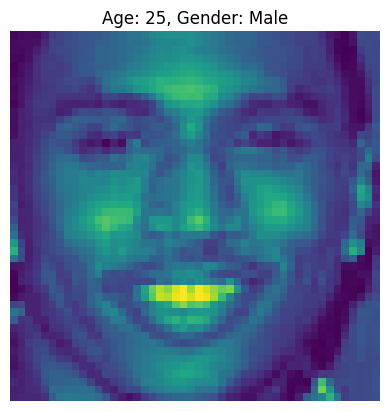

In [52]:
random_face = np.random.choice(len(df))
age_gender_prediction(df['pixels'][random_face])